# A Scalable DAG Scheduler

### JuliaCon 2018, London

<!--
Computational problems can often be represented as specific types of graphs known as DAGs. That allows an execution framework to execute parts in right order, schedule in parallel, and make optimal use of available resources. We present ideas on which we are building a scalable scheduler for Julia.
-->
<!--
We at Julia Computing are working on a scheduler for running large DAGs (directed acyclic graphs) on many nodes in parallel. Though the concepts it is being built on are generic, it currently leverages on the existing Julia package Dagger (for representing computation DAGs) and is intended to be used with JuliaRun (to deploy Julia applications in production at scale).
-->
<!--
Based on experiences in running large scale DAG computations with JuliaDB, this talk will present problems we encountered and our approach to tackle them. In particular: - minimizing data transfer across process and node boundaries - inter-process data transfer without blocking computation - avoiding single point scheduler bottleneck - graceful failure handling
-->

# DAG

- directed acyclic graph
- finite directed graph with no directed cycles
- edges are functions
- vertices are inputs to them

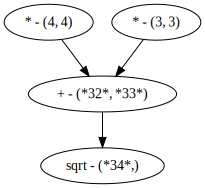

In [14]:
using Dagger, GraphViz

# √(a² + b²)
a, b = 4, 3
a² = delayed(*)(a, a)
b² = delayed(*)(b, b)
sqsum = delayed(+)(a², b²)
dag = delayed(sqrt)(sqsum)

Graph(Dagger.show_plan(dag))

In [12]:
collect(dag)  # execute and get result

5.0

# DAG

DAG representation helps determine:
- correct evaluation order
- reusable units
- blocks with special resource requirements

Useful to determine how to:
- parallelize
- schedule

# Consideratons for Scheduling

- Ordering & Parallelization
- Data Locality
- Resource Optimization
- Scalability
- Resilience

# Broad Level Goals
- Prioritize tasks that will promote parallelization
- Minimize resource wastage, maximize resources usablilty
- Ability to tweak conflicting goals
- Distributed scheduling for scalability

# Approach

# Decompose DAG

Break up DAG into smaller chunks.

Based on:

- layers
    e.g. redistribution/broadcast of previous layer output
- dependency
    - on specific resources (e.g. GPU)
    - on same set of inputs

# Distribute Scheduling Load

- Central (cluster level) coarse scheduling
    - based on DAG chunks
- Local (node level) fine scheduling

# Minimize Data Movement

- Compute where data is
    - Same process
    - Same node
- But without overloading any single point!

- Queue based task stealing
- Tasks beyond threshold can be stolen
- Process ⇌ Node ⇌ Cluster

# Offload Expensive IO

- Reason:
    - can not (yet) do IO and compute in parallel
    - processes often wait for results from another that is busy in a compute
    - inter-node communication is expensive
- Node level broker process for inter-node
    - data exchange
    - task sharing/stealing

# Resilience

- Track point of execution (node level)
- Detect node/process failure
    - process failure triggers a node reset
- Reschedule failed tasks

# Architecture

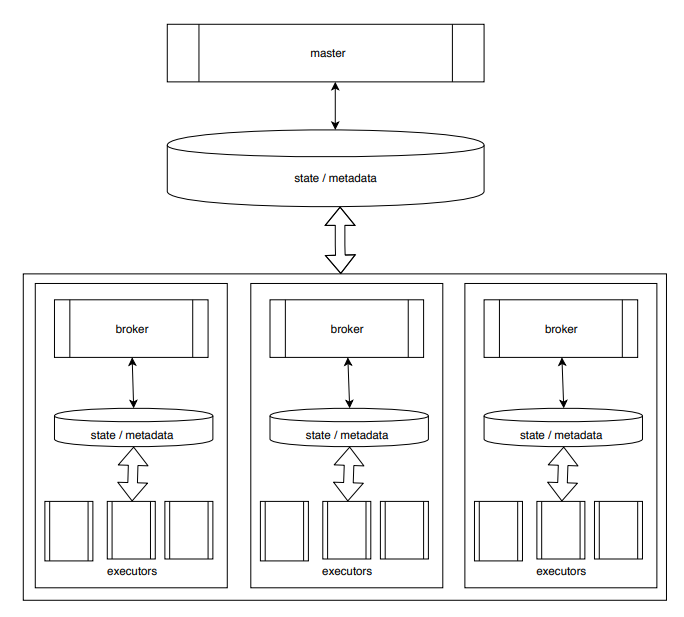

# Preliminary Results

```
Running sort comparison
Node Meta: DagScheduler.ShmemMeta.ShmemExecutorMeta
Cluster Meta: DagScheduler.SimpleMeta.SimpleExecutorMeta
- dagger.jl
  345.036 ms (31319 allocations: 1.57 MiB)
- dagscheduler.jl
  45.869 ms (15915 allocations: 1.05 MiB)
- dagscheduler_2node.jl
  54.092 ms (16783 allocations: 845.92 KiB)
```

```
Running sort comparison with distributed results
Node Meta: DagScheduler.ShmemMeta.ShmemExecutorMeta
Cluster Meta: DagScheduler.SimpleMeta.SimpleExecutorMeta
- dagger.jl
  2.459 s (1357843 allocations: 73.66 MiB)
- dagscheduler.jl
  378.567 ms (323169 allocations: 18.09 MiB)
- dagscheduler_1node.jl
  548.678 ms (280794 allocations: 15.60 MiB)
- dagscheduler_2node.jl
  623.153 ms (541577 allocations: 28.58 MiB)
  ```

```
Running deep dag comparison
Node Meta: DagScheduler.ShmemMeta.ShmemExecutorMeta
Cluster Meta: DagScheduler.SimpleMeta.SimpleExecutorMeta
- dagger.jl
  711.763 ms (2328546 allocations: 270.96 MiB)
- dagscheduler.jl
  222.438 ms (228670 allocations: 16.63 MiB)
- dagscheduler_2node.jl
  229.976 ms (125307 allocations: 5.84 MiB)
```

# Demo

# Thanks!